[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/prokaj/elte-python/blob/main/13-gyakorlat.ipynb)

In [287]:
def on_colab():
    import sys
    return 'google.colab' in sys.modules


def on_vscode():
    import os
    return 'VSCODE_PID' in os.environ

if on_vscode():
    from tqdm import tqdm
else:
    from tqdm.auto import tqdm

# MNIST

Kézzel írt számjegyek, és sok más ehhez hasonló szerkezetű adathalmaz, pl. fashionMNIST

Feladat kategorizálni a képeket az ábrázolt számjegy alapján.

In [288]:
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    ! pip install  tensorflow-datasets tensorflow

In [289]:
import tensorflow as tf
import tensorflow_datasets as tfds

ds = tfds.load('mnist', split='train', shuffle_files=False)
print(len(ds))



60000


In [290]:
train = ds.take(50_000).cache()
test = ds.skip(50_000).take(10_000).cache()
len(train), len(test)

(50000, 10000)

In [291]:
it = train.batch(64).as_numpy_iterator()


2022-12-03 19:55:39.149013: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [292]:
example = next(it)
#iter(train.batch(64).take(1).as_numpy_iterator())) 
image, label = example['image'], example['label']

(8, 8, 28, 28)


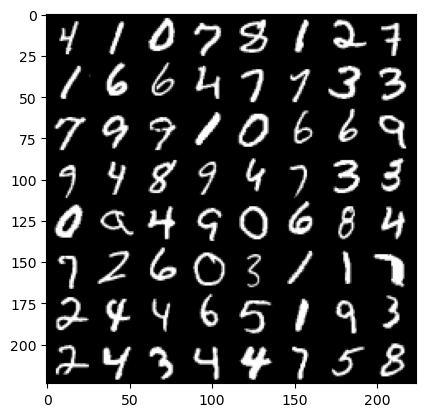

[[4 1 0 7 8 1 2 7]
 [1 6 6 4 7 7 3 3]
 [7 9 9 1 0 6 6 9]
 [9 4 8 9 4 7 3 3]
 [0 9 4 9 0 6 8 4]
 [7 2 6 0 3 1 1 7]
 [2 4 4 6 5 1 9 3]
 [2 4 3 4 4 7 5 8]]


In [293]:
import matplotlib.pyplot as plt
import numpy as np

img0 = image[:64].reshape(8,8,28,28)
print(img0.shape)
img0 = np.transpose(img0, axes=(0,2,1,3)).reshape(8*28, 8*28)
plt.imshow(img0, cmap="gray")
plt.show()
print(label[:64].reshape(8,8))

In [294]:
image.shape, label.shape

((64, 28, 28, 1), (64,))

## Feladat: Kategorizáljuk a képeket
## Hogyan lehet ilyesmit leprogramozni?

Az első ötletünk az lehet, hogy próbáljuk megérteni, mitől érzékelünk egy képet 1-esnek, 2-esnek, stb. majd ezt valahogy formalizáljuk végül lekódoljuk.

Ez teljesen reménytelennek tűnik. Ehelyett inkább olyan eljárást keresünk, ami egy könnyen számolható függvény osztályból kiválaszt egyet, ami az esetek többségében jól működik. 

#### Milyen függvény osztályok jöhetnek szóba?

A függvény bemenete egy kép, jelen esetben szürkeárnyalatos 28x28 pixeles kép. Azaz minden bemenet 28x28 intenzitás értékkel van megadva. 
Erre gondolhatunk úgy, hogy egy 784 dimenziós (valós) vektorra. 


Mi lenne a függvény kimenete? 10 lehetséges kategória (osztály) között kell választani. Ezért a kimenet lehetne egy egész 0 és 9 között, de egyszerűbb 10 értéket kiszámolni és aztán a döntés a legnagyobb érték indexe.  

Azaz keresünk egy
$$
    g:\mathbb{R}^{784} \to \mathbb{R}^{10}, \quad f = \arg\max(g)
$$

A legegyszerűbb függvények a lineáris függvények, ezek könnyen paraméterezhetőek.

Általában is függvény osztály elemeit paraméteresen adjuk meg és a paramétereket szeretnénk azonosítani. 


## Paraméterek keresése, veszteség minimalizálás

Mikor gondolnánk egyik függvényt jobbnak mint a másikat? Nyilván akkor, ha több helyest döntést hoz. Azaz $g_0(x_i),\dots,g_9(x_i)$ értékek 
közül az esetek többségében az $y_i$ indexű a legnagyobb, ahol $(x_i,y_i)$ az ismert input-output párokat jelöli.

Egy lehetséges kritérium, hogy az $y_i$ indexet 0-1 vektorként kódoljuk $z_i=(\mathbb{1}_{k=y_i})_{k=0}^9$ és olyan $g$-t keresünk, amire
$$
    \sum_i \|g(x_i) - z_i\|^2 
$$
minimális.

Egy másik lehetőség lehetne, hogy a
$$
    \sum_i \sum_k (2z_{i,k}-1)*g_k(x_i)
$$
kifejezést próbálnánk maximalizálni. Ezzel az a gond, hogy felülről nem feltétlenül korlátos.

Egy további lehetőség lehetne, hogy a
$$
    \sum_i \sum_k \max(1-(2z_{i,k}-1)*g_k(x_i),0)
$$
minimalizálása, vagy
$$
    \sum_i -\log p_{y_i}(x_i), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_\ell e^{g_\ell(x)}}
$$
minimalizálása.

Ezekben az a közös, hogy megfogalmazhatóak egy ($x$-ben differenciálható) veszteség minimalizálásaként.


## Gradiens ereszkedés (Gradient descent)
Néhány esetben a megoldás kifejezhető az $(x_i, y_i)$ párok segítségével, de még ezekben az esetekben is inkább általános iterative eljárást szoktak használni. 

A $g(x)$ valójában $g(x,\vartheta)$, ahol $\vartheta$ a függvény megadására szolgáló paraméter vektor. pl. ha $g$ lineáris, akkor
$$
    g(x) = b + Ax,\quad \vartheta=(b, A),\quad b\in\mathbb{R}^{10},\quad A\in\mathbb{R}^{10\times 784}, \quad x\in\mathbb{R}^{784}
$$

Azaz $g$ a paraméter szerint is deriválható. Ha $\ell$ jelöli a veszteség függvényt, akkor
$$
    \hat\vartheta = \arg\min_{\theta}L(\vartheta), \quad L(\vartheta) = \frac1n\sum_{i} \ell (g(x_i,\vartheta), y_i)
$$
úgy is számolható, hogy
$$
    \vartheta_{n+1} = \vartheta_n -\eta L'(\vartheta_n)
$$
ahol $\eta$ általában egy kicsi szám, a tanulási ráta. Mindig abba az irányba próbáljuk $\vartheta_n$-t módosítani amerre a leginkább csökken.
Ezt a minimalizálási eljárást gradiens ereszkedésnek hívják.

Gyakran nem kell $L'$-t pontosan számolni elegendő az adatok egy $b$ részét használni, Azaz $L'$ helyett $L'_b$-t használjuk, ahol
$$
    L'_b(\vartheta)=\frac{1}{|b|}\sum_{i\in b} \partial_\vartheta\ell(g(x_i, \vartheta), y_i)
$$

Szerencsére a derivált számolást nem kell leprogramozni. A neurális hálós keretrendszerek mind megteszik ezt nekünk. Mi a `jax` könytárat fogjuk használni.



In [295]:
try:
    import jax
except ModuleNotFoundError:
    ! pip install jax[cpu]


In [296]:
from jax import grad
import jax.numpy as jnp

def tanh(x):  # Define a function
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))   # Evaluate it at x = 1.0
# prints 0.4199743

0.4199743


In [297]:
import jax
import jax.numpy as jnp

In [298]:
def g(theta, x):
    x = x.reshape(-1)
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), np.random.normal(size=(10, 784))

In [300]:
x = image[0]
pred = g(theta, x)
print(f'scores:\n {list(pred.round(2))}\nVajon {f(pred)} van a képen ?')

scores:
 [-1952.79, -605.57, 518.94, 1761.93, -1933.25, 286.18, 1023.05, 714.55, 2108.95, -1739.03]
Vajon 8 van a képen ?


Szerencsésebb lenormálni az $A$ mátrixot, és a képet is.

In [301]:
image[0].max()

255

In [302]:
def g(theta, x):
    x = x.reshape(-1)/255
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))

[ 2.14695889 -0.09117814  1.51068384  1.37780584 -0.22931983 -0.83690913
 -0.95061831  0.44538005 -0.39437405 -0.64074461]
A képen 0 van?


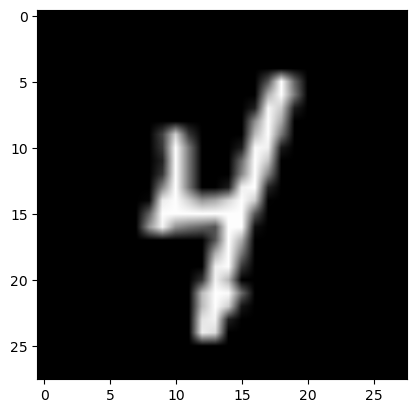

In [303]:

x = image[0]
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')
plt.imshow(x.squeeze(), cmap='gray', interpolation='bilinear')

## Veszteség függvény

Válasszuk a keresztentrópiát:
$$
    \sum_i -\log p_{y_i}(x_i)=\sum -g_{y_i}(x_i)+\log(\sum_je^{g_j(x_i)}), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_j e^{g_j(x)}}
$$

In [304]:
def ell(pred, y):
    return jax.nn.log_softmax(pred) @ y

def ell(pred, y):
    return -pred@y + jax.nn.logsumexp(pred)


In [305]:
y = jax.nn.one_hot(label[0], 10)
pred = g(theta, x)
log_p = jax.nn.log_softmax(pred)
print(f'pred: \t{pred}\none-hot:\t{y}\nlog p:\t{log_p}\nloss:\t{ell(pred, y)}')

pred: 	[ 2.14695889 -0.09117814  1.51068384  1.37780584 -0.22931983 -0.83690913
 -0.95061831  0.44538005 -0.39437405 -0.64074461]
one-hot:	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
log p:	[-0.9596155 -3.1977525 -1.5958905 -1.7287686 -3.335894  -3.9434834
 -4.057193  -2.6611943 -3.5009484 -3.747319 ]
loss:	3.3358941078186035


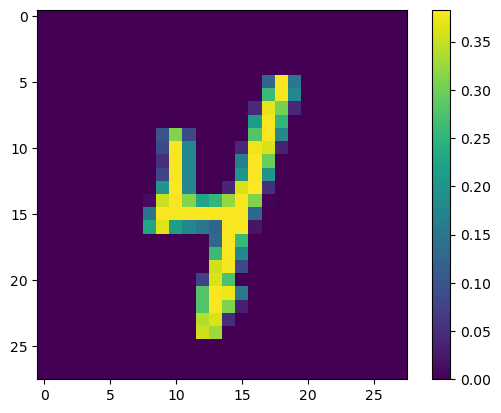

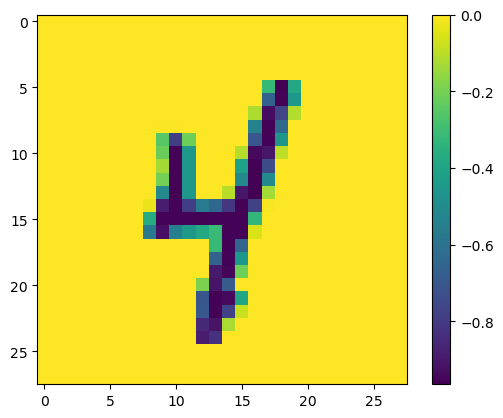

In [307]:
def loss(theta, x, y):
    pred = g(theta, x)
    return ell(pred, y)

dL = grad(loss)

dx, dA = dL(theta, x, y)

plt.imshow(dA[0].reshape(28,28))
plt.colorbar()
plt.show()

plt.imshow(dA[4].reshape(28,28))
plt.colorbar()
plt.show()

In [308]:
batched_loss = jax.vmap(loss, in_axes=None)
batched_loss(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))


DeviceArray([3.2972322, 2.8897378, 0.9737847, 2.8482153, 3.2245338,
             2.888842 , 1.7602891, 2.8469625, 2.8902645, 4.1661305,
             4.164564 , 3.2952867, 2.8473873, 2.8479338, 1.5519149,
             1.5530523], dtype=float32)

In [309]:
def mean_loss(theta, x, y):
    return batched_loss(theta, x=x, y=y).mean(axis=0)

def training_step(theta, x, y, eta):
    y = jax.nn.one_hot(y, 10)
    loss, gradient = jax.value_and_grad(mean_loss)(theta, x=x, y=y)
    return loss, jax.tree_map(lambda t, g: t-eta*g, theta, gradient)

In [310]:
# loss_fn(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))
loss, gradient = training_step(theta, x=image[:16], y=label[:16], eta=0.1)

In [312]:
gradient

(DeviceArray([ 2.089168  ,  0.21909475,  1.3179375 ,  1.5408282 ,
              -0.19340457, -0.9108945 , -1.0591509 ,  0.26498213,
              -0.124664  , -1.1613485 ], dtype=float32),
 DeviceArray([[-0.08752145, -0.03044681,  0.0524051 , ...,  0.03467999,
               -0.00289979, -0.02523666],
              [-0.00831831,  0.0429297 , -0.00515481, ...,  0.0386862 ,
               -0.01604162,  0.01793881],
              [ 0.01030131, -0.02196775,  0.01694957, ..., -0.05954105,
                0.03701905,  0.00054545],
              ...,
              [ 0.00780183,  0.05043623, -0.03822856, ...,  0.05503324,
                0.00215452,  0.00736961],
              [-0.03289913, -0.00223356, -0.04831852, ...,  0.0275781 ,
                0.00978259,  0.00376552],
              [ 0.11708471, -0.0523842 , -0.01169722, ...,  0.01649441,
                0.01066905,  0.03913567]], dtype=float32))

In [313]:
theta = theta = 0.1 * np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))
eta = 0.05
losses = []
n_iter = 2000
batch_size = 512
print(f'approx {n_iter*batch_size/len(train)} epochs')

for i, example in tqdm(enumerate(train.repeat().shuffle(512*16).batch(batch_size).take(n_iter).as_numpy_iterator())):
    img, label = example['image'], example['label']
    loss, theta = training_step(theta, img, label, eta)
    losses.append(loss)
    # eta *= 0.995
    # if (i+1) % 200==0:
    #     eta *= 0.5

approx 20.48 epochs


76it [00:01, 53.96it/s]2022-12-03 19:57:46.477455: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2000it [00:26, 74.67it/s]


In [314]:
eta

0.05

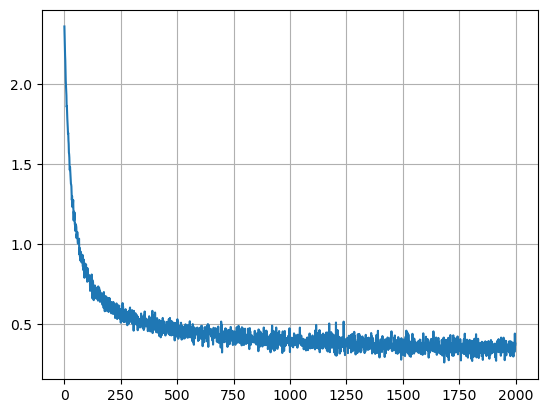

In [315]:
plt.plot(losses)
plt.grid()
plt.show()

In [316]:
def predict(theta, x):
    return jax.vmap(g, in_axes=None)(theta, x=x).argmax(axis=1)

In [317]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def cm_(y_true, y_pred, classes=None):
    if classes is None:
        classes = np.unique(y_true)
    cm = pd.DataFrame(
        confusion_matrix(
            y_pred=y_pred, 
            y_true=y_true, 
            labels=classes
            ), 
            columns=classes, 
            index=classes)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm


In [347]:
preds = []
labels = []
def predict(theta, img):
    return jax.vmap(g, in_axes=None)(theta, x=img).argmax(axis=1)

for example in tqdm(test.batch(256).as_numpy_iterator()):
    img, label = example['image'], example['label']
    preds.append(predict(theta, img))
    labels.append(label)

preds = np.concatenate(preds)
labels = np.concatenate(labels)
print(f'test accuracy: {(labels==preds).mean()}')
cm_(y_pred=preds, y_true=labels)
#confusion_matrix(y_pred=preds, y_true=label, labels=range(10))

40it [00:00, 302.91it/s]

test accuracy: 0.9037


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,916,0,6,5,1,10,7,1,12,1
1,1,1090,6,8,1,6,0,4,12,1
2,7,11,878,10,24,2,19,21,24,3
3,7,4,22,903,1,38,2,7,16,17
4,2,9,9,1,910,3,11,1,5,36
5,14,6,9,37,18,758,17,5,31,17
6,5,5,11,2,14,17,928,1,5,0
7,6,10,16,2,14,0,0,977,0,32
8,8,30,18,34,9,23,7,6,818,20


In [349]:
preds = []
labels = []
for example in train.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print(f'train accuracy: {(labels==preds).mean()}')
cm_(y_pred=preds, y_true=labels)


train accuracy: 0.90378


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4785,0,21,11,11,32,40,6,50,8
1,0,5428,25,24,5,36,7,13,66,9
2,44,61,4315,89,91,17,87,84,134,37
3,22,33,123,4444,4,224,33,68,105,58
4,13,25,35,5,4429,3,48,12,30,255
5,78,46,34,170,59,3805,82,20,144,71
6,43,17,54,3,39,65,4658,2,45,4
7,34,61,81,21,59,10,2,4725,16,199
8,28,130,66,142,19,146,42,22,4189,94


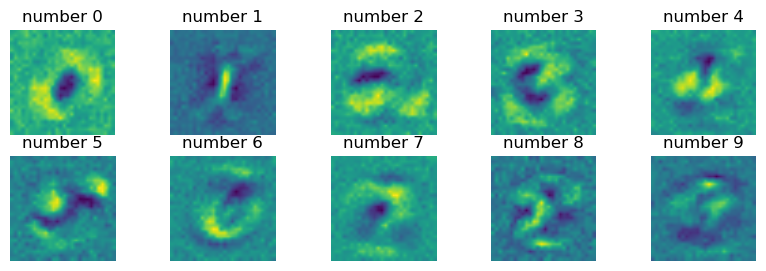

In [350]:
fig, axs = plt.subplots(2, 5)
#fig.tight_layout()
fig.set_figheight(3)
fig.set_figwidth(10)
for ax in axs.flatten():
    ax.set_axis_off()
b, A = theta
for i, (row, ax) in enumerate(zip(A, axs.flatten())):
    ax.imshow(row.reshape(28, 28), interpolation='bilinear')
    ax.set_title(f'number {i}')
    ax.set_axis_off()
plt.show()

## Több rétegű neurális háló

Lineáris függvények családja nagyon szűk. 

Az derül ki, hogy ha $g_1\circ \sigma\circ g_2$ alakban már tetszőleges (folytonos) függvény közelíthető, ha a közepső tér dimenziója elég nagy és
$\sigma$ egy koordinátánként számolt nem lineáris **aktivációs** függvény. Szokásos választások $\sigma$-ra $\sigma(x)=\max(x,0)$,  vagy $\sigma(x)=\tanh(x)$, vagy $\sigma(x)=1/(1+e^{-x})$ (mindegyik koordinátánként értendő).

A következő rész a `jax` dokumentációjában szereplő példa.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/Neural_Network_and_Data_Loading.ipynb)

In [351]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

A véletlen számokat a `jax` rendszer kicsit másképp kezeli. A véletlenszám generátornak mindig meg kell adni egy kulcsot (a generátor állapotát).
Új véletlenszám generálása előtt a kulcsot szét kell bontani, az egyikből az aktuális érték(ek)et szzámoljuk, a másikból a következőket.

In [368]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 300, 300, 100, 10]
params = init_network_params(layer_sizes, random.PRNGKey(0))

A `predict` függvény hasonló a fentihez, de most minden (rejtett) réteg után alkalmazunk egy `relu` (rectified linear unit, igazából pozitív rész) nem linearitást, vagy aktivációs függvényt. 

In [371]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

relu = jax.nn.relu

def forward(params, image):
  # per-example predictions
  activations = image.flatten()/255.0
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return jax.nn.log_softmax(logits)
  # logits - logsumexp(logits)

In [372]:
# This works on single examples
preds = forward(params, image[0])
print(preds.shape)
print(preds)

(10,)
[-2.2996094 -2.2999055 -2.3081307 -2.292938  -2.2926476 -2.305837
 -2.3034883 -2.2916498 -2.325132  -2.306959 ]


Ugyanúgy mint a lineáris esetben a `predict` függvény nem képes több képet egyszerre kezelni. 

In [373]:
try:
  preds = forward(params, image[:10])
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


A `vmap` transzformáció most is segít.

In [374]:
forward_fn = vmap(forward, in_axes=(None, 0))

batched_preds = forward_fn(params, image[:8])
print(batched_preds.shape)

(8, 10)


In [330]:
n_targets = 10

In [375]:
def y_pred_true(model, params, dataset):
    y_pred = []
    y_true = []
    for example in dataset.batch(256).as_numpy_iterator():
        images, targets = example['image'], example['label']
        y_pred.append(model(params, images).argmax(axis=-1))
        y_true.append(targets)

    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return pd.DataFrame({'y_pred': y_pred, 'y_true':y_true})

def accuracy(model, params, dataset):
    y = y_pred_true(model, params, dataset)
    acc = sum(y['y_pred'] == y['y_true'])
    n = len(y['y_pred'])
    return acc/n

def mean_loss(params, images, targets):
    targets = jax.nn.one_hot(targets, n_targets)
    preds = forward_fn(params, images)
    return -jnp.mean(preds * targets)*n_targets

@jit
def update(params, x, y):
    grads = grad(mean_loss)(params, x, y)
    return jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)


Konstansok:

In [376]:
learning_rate = 0.05
num_epochs = 20
batch_size = 128


In [377]:
import time

for epoch in range(num_epochs):
  start_time = time.time()
  
  for example in tqdm(train.shuffle(5000).batch(batch_size).as_numpy_iterator(), leave=False):
    x, y = example['image'], example['label']
    params = update(params, x, y)

  epoch_time = time.time() - start_time

  train_acc = accuracy(forward_fn, params, train)
  test_acc  = accuracy(forward_fn, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 1.67 sec
Training set accuracy 0.11226
Test set accuracy 0.1129


Epoch 1 in 1.16 sec
Training set accuracy 0.11226
Test set accuracy 0.1129


Epoch 2 in 1.20 sec
Training set accuracy 0.11226
Test set accuracy 0.1129


Epoch 3 in 1.14 sec
Training set accuracy 0.11226
Test set accuracy 0.1129


Epoch 4 in 1.16 sec
Training set accuracy 0.11226
Test set accuracy 0.1129


Epoch 5 in 1.31 sec
Training set accuracy 0.293
Test set accuracy 0.2934


Epoch 6 in 1.20 sec
Training set accuracy 0.66074
Test set accuracy 0.6684


Epoch 7 in 1.17 sec
Training set accuracy 0.816
Test set accuracy 0.8211


Epoch 8 in 1.14 sec
Training set accuracy 0.87868
Test set accuracy 0.8799


Epoch 9 in 1.21 sec
Training set accuracy 0.90592
Test set accuracy 0.905


Epoch 10 in 1.14 sec
Training set accuracy 0.91846
Test set accuracy 0.9149


Epoch 11 in 1.19 sec
Training set accuracy 0.93674
Test set accuracy 0.9342


Epoch 12 in 1.15 sec
Training set accuracy 0.94372
Test set accuracy 0.9366


Epoch 13 in 1.15 sec
Training set accuracy 0.95754
Test set accuracy 0.9486


Epoch 14 in 1.15 sec
Training set accuracy 0.9639
Test set accuracy 0.9558


Epoch 15 in 1.15 sec
Training set accuracy 0.96308
Test set accuracy 0.9527


Epoch 16 in 1.14 sec
Training set accuracy 0.96676
Test set accuracy 0.9556


Epoch 17 in 1.15 sec
Training set accuracy 0.97374
Test set accuracy 0.9601


Epoch 18 in 1.17 sec
Training set accuracy 0.97214
Test set accuracy 0.9585


Epoch 19 in 1.20 sec
Training set accuracy 0.9772
Test set accuracy 0.9643


In [378]:
train_y = y_pred_true(batched_predict, params, train)
print(f'train accuracy: {(train_y.y_pred==train_y.y_true).mean()}')
cm_(train_y['y_pred'], train_y['y_true'])

train accuracy: 0.9772


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4876,0,2,1,0,17,6,1,0,4
1,0,5577,21,5,6,0,1,31,57,7
2,7,17,4885,61,3,6,7,11,44,0
3,0,1,4,4905,0,39,0,2,1,5
4,1,3,5,0,4803,2,13,10,15,68
5,12,0,3,26,0,4282,0,0,4,8
6,56,0,3,0,16,19,4895,0,18,1
7,0,12,9,29,4,0,0,5104,3,36
8,12,3,27,69,4,113,8,3,4718,26


In [379]:
test_y = y_pred_true(batched_predict, params, test)
print(f'test accuracy: {(test_y.y_pred==test_y.y_true).mean()}')
cm_(test_y['y_pred'], test_y['y_true'])

test accuracy: 0.9643


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,929,0,0,0,1,4,6,0,0,1
1,0,1106,11,0,4,0,1,2,14,4
2,1,9,971,11,3,2,0,5,9,0
3,0,0,3,967,0,12,0,2,10,4
4,2,4,4,0,965,2,6,2,3,18
5,5,0,0,6,0,845,0,0,2,3
6,18,1,1,0,4,10,973,0,6,0
7,0,5,7,10,4,1,0,1032,1,9
8,3,4,2,21,0,26,2,1,921,6


## Konvolúciós háló

Az ötlet az, hogy a kép kis részeit tekintsük, pl. az összes 5*5-ös részképet és mindegyikre ugyanazt a lineáris leképezést alkalmazzuk, majd az eredményekre az aktivációs függvényt. Ezzel kapunk egy másik (gyakran kisebb) képet ahol, nem 1 vagy 3 ,,szín'' van, hanem sok, attól függően, hogy hány ismérvet számolunk ki a kis képből. Ezzel a kép lokális tulajdonságait lehet kigyűjteni (van vonal vagy nincs, annak az iránya stb). Ilyen rétegeket pakolunk egymásra és a végén a kapott képre az imént látott összegzést alkalmazzuk.
 


In [380]:
try:
    import haiku as hk
except ModuleNotFoundError:
    ! pip install dm-haiku

In [ ]:
hk.MaxPool?

In [ ]:
hk.transform?

In [ ]:
hk.Bias?

Init signature: hk.Bias(*args, **kwargs) -> ~T
Source:        
class Bias(hk.Module):
  """Adds a bias to inputs.

  Example Usage:

  >>> N, H, W, C = 1, 2, 3, 4
  >>> x = jnp.ones([N, H, W, C])
  >>> scalar_bias = hk.Bias(bias_dims=[])
  >>> scalar_bias_output = scalar_bias(x)
  >>> assert scalar_bias.bias_shape == ()

  Create a bias over all non-minibatch dimensions:

  >>> all_bias = hk.Bias()
  >>> all_bias_output = all_bias(x)
  >>> assert all_bias.bias_shape == (H, W, C)

  Create a bias over the last non-minibatch dimension:

  >>> last_bias = hk.Bias(bias_dims=[-1])
  >>> last_bias_output = last_bias(x)
  >>> assert last_bias.bias_shape == (C,)

  Create a bias over the first non-minibatch dimension:

  >>> first_bias = hk.Bias(bias_dims=[1])
  >>> first_bias_output = first_bias(x)
  >>> assert first_bias.bias_shape == (H, 1, 1)

  Subtract and later add the same learned bias:

  >>> bias = hk.Bias()
  >>> h1 = bias(x, multiplier=-1)
  >>> h2 = bias(x)
  >>> h3 = bias(x, mult

In [427]:
act = jax.nn.tanh
pool = hk.AvgPool
hk.Bias

def lenet5(x):
    ## b x 28 x 28 x 1
    x = x.astype(jnp.float32)/255
    x = hk.Conv2D(6, 5, stride=1, padding='SAME')(x) # -> b x 28 x 28 x 6
    x = act(x)
    x = pool(2, 2, padding='VALID')(x) # b x 14 x 14 x 6
    x = hk.Conv2D(16, 5, stride=1, padding='VALID')(x) # -> b x 10 x 10 x 16
    x = act(x)
    x = pool(2, 2, padding='VALID')(x) # -> b x 5 x 5 x 16
    x = act(x)
    x = hk.Conv2D(120, 5, stride=1, padding='VALID')(x) # -> b x 1 x 1 x 120
    x = act(x)
    x = x[:, 0, 0]
    x = hk.Linear(84)(x)
    return x

    

def cnn(x):
    ## b x 28 x 28 x 1
    x = x.astype(jnp.float32)/255
    x = hk.Conv2D(32, 5, stride=1, padding='SAME')(x) # -> b x 28 x 28 x 32
    x = jax.nn.relu(x)
    x = pool(2, 2, padding='VALID')(x) # b x 14 x 14 x 32
    x = hk.Conv2D(64, 3, padding='VALID')(x) # b x 12 x 12 x 64
    x = jax.nn.relu(x)
    x = hk.Conv2D(64, 3, padding='VALID')(x) # b x 10 x 10 x 64
    x = jax.nn.relu(x)
    x = pool(2, 2, padding='VALID')(x) # b x 5 x 5 x 64
    x = hk.Conv2D(128, 5, padding='VALID')(x)
    x = hk.Flatten()(x)
    x = jax.nn.relu(x)
    x = hk.Linear(10)(x)
    x = jax.nn.log_softmax(x, axis=-1)
    return x


In [428]:
net = cnn

init_fn, apply_fn = hk.transform(net)

@jax.jit
def forward_fn(params, images):
    return apply_fn(params, None, images)


def mean_loss(params, images, targets):
  targets = jax.nn.one_hot(targets, n_targets)
  preds = forward_fn(params, images)
  return -jnp.mean(preds * targets)*n_targets

@jax.jit
def net_update(params, x, y):
  grads = grad(mean_loss)(params, x, y)
  return jax.tree_map(lambda p, g: p - step_size * g, params, grads)


In [429]:
key = jax.random.PRNGKey(0)
params = init_fn(key, image[:10])

In [430]:
import time

def predict(params, x):
  return forward_fn(params, x).argmax(axis=-1)

for epoch in range(10):
  start_time = time.time()
  for example in tqdm(train.shuffle(5000).batch(128).as_numpy_iterator(), leave=False):
    x, y = example['image'], example['label']
    params = net_update(params, x, y)
  
  epoch_time = time.time() - start_time

  train_acc = accuracy(forward_fn, params, train)
  test_acc = accuracy(forward_fn, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 34.42 sec
Training set accuracy 0.95586
Test set accuracy 0.9544


Epoch 1 in 33.50 sec
Training set accuracy 0.97214
Test set accuracy 0.9708


Epoch 2 in 33.34 sec
Training set accuracy 0.97202
Test set accuracy 0.9687


Epoch 3 in 33.27 sec
Training set accuracy 0.98706
Test set accuracy 0.9819


Epoch 4 in 33.49 sec
Training set accuracy 0.98592
Test set accuracy 0.9786


Epoch 5 in 33.04 sec
Training set accuracy 0.99068
Test set accuracy 0.9831


Epoch 6 in 33.06 sec
Training set accuracy 0.98836
Test set accuracy 0.9808


Epoch 7 in 33.12 sec
Training set accuracy 0.99288
Test set accuracy 0.9841


Epoch 8 in 32.97 sec
Training set accuracy 0.9943
Test set accuracy 0.9863


Epoch 9 in 33.30 sec
Training set accuracy 0.99304
Test set accuracy 0.9858


In [431]:
test_y = y_pred_true(forward_fn, params, test)
print(f'test accuracy: {(test_y.y_pred==test_y.y_true).mean()}')
cm_(test_y['y_pred'], test_y['y_true'])

test accuracy: 0.9858


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,950,1,0,0,1,2,3,0,1,1
1,0,1102,1,0,1,0,0,0,0,0
2,0,8,989,4,3,0,1,4,2,2
3,0,2,2,1009,0,6,0,3,2,8
4,1,1,0,0,976,0,1,0,2,5
5,1,0,0,1,1,895,1,0,3,4
6,3,1,0,0,1,1,980,0,0,0
7,1,6,3,0,0,1,0,1047,0,6
8,3,6,4,2,1,7,2,2,963,6


In [432]:
badly_classified = {
    i: next(test.skip(i).take(1).as_numpy_iterator()) 
    for i in np.where(test_y.y_true!=test_y.y_pred)[0]
}   

In [433]:
len(badly_classified)

142

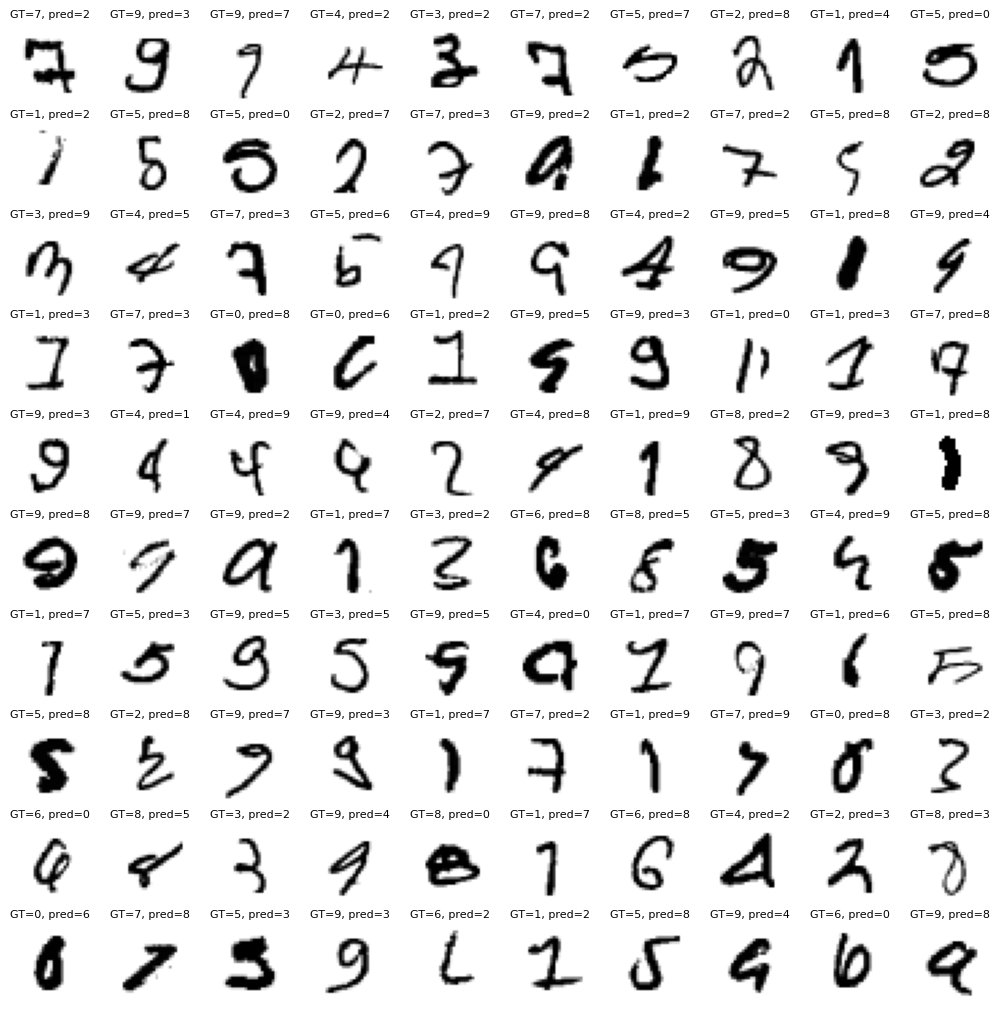

In [434]:
fig, axs = plt.subplots(10, 10, constrained_layout = True)
#fig.tight_layout()
fig.set_figwidth(10)
fig.set_figheight(10)

for ((k, v), ax) in zip(badly_classified.items(), axs.flatten()):
    ax.set_title(f'GT={test_y.y_true[k]}, pred={test_y.y_pred[k]}', fontdict={'fontsize':8})
    ax.imshow(v['image'], cmap='gray_r')
    ax.set_axis_off()
    ax.set_ymargin(20)